In [1]:
import numpy as np
import astropy.units as u
from astropy.constants import c
import matplotlib.pyplot as plt
import matplotlib as mpl
import sys
import os
from synphot import SpectralElement, Empirical1D, SourceSpectrum, Observation
from scipy.interpolate import CubicSpline
from scipy.signal import savgol_filter

SPEC_PIPE_LOC = "{}/JPL/W12_Drops/spec_paper/Spec_pipeline".format(os.path.expanduser("~"))
sys.path.append(SPEC_PIPE_LOC)
os.environ['SPEC_PIPE_LOC'] = SPEC_PIPE_LOC
from Spec_pipeline import SDSS_Spec, GMOS_Spec, DBSP_Spec

sys.path.append("Gas_and_dust/")
from draine_dust import draine_dust

sys.path.append("Gas_and_dust/fullspec_dust_models/")
from polWave import PolWave

from polWave_gas import PolWave_gas

In [2]:
#Measured polarizations. 
pol_data = dict()

wid = 'W0116-0505'
pol_data[wid] = dict()
pol_data[wid]['bands'] = ['v', 'R', 'I']
pol_data[wid]['pfrac'] = [0.0973, 0.109, 0.147]
pol_data[wid]['host_frac'] = [1.0, 1.0, 1.0]
pol_data[wid]['z'] = 3.173
pol_data[wid]['spec'] = SDSS_Spec(wid, pol_data[wid]['z'], "spec-7046-56568-0425.fits")
pol_data[wid]['eps'] = 0.0062

wid = 'W0019-1046'
pol_data[wid] = dict()
pol_data[wid]['bands'] = ['R']
pol_data[wid]['pfrac'] = [0.064]
pol_data[wid]['host_frac'] = [0.70]
pol_data[wid]['z'] = 1.641
pol_data[wid]['spec'] = DBSP_Spec(wid, pol_data[wid]['z'], "w0019m1046_b.f.fits", blue=True)
pol_data[wid]['eps'] = 0.0098

wid = 'W0220+0137'
pol_data[wid] = dict()
pol_data[wid]['bands'] = ['R']
pol_data[wid]['pfrac'] = [0.129]
pol_data[wid]['host_frac'] = [0.83]
pol_data[wid]['z'] = 3.122
pol_data[wid]['spec'] = SDSS_Spec(wid, pol_data[wid]['z'], "spec-4267-55484-0056.fits")
pol_data[wid]['eps'] = 0.0042

wid = 'W0204-0506'
pol_data[wid] = dict()
pol_data[wid]['bands'] = ['R']
pol_data[wid]['pfrac'] = [0.253]
pol_data[wid]['host_frac'] = [0.96]
pol_data[wid]['z'] = 2.100
pol_data[wid]['spec'] = GMOS_Spec(wid, pol_data[wid]['z'], "W0204m0506.f.fits", inst_conf={"grating":"B600", "detector":"EEV", "slit_width":1.5})
pol_data[wid]['eps'] = 0.0020

wid = 'W0831+0140'
pol_data[wid] = dict()
pol_data[wid]['bands'] = ['R']
pol_data[wid]['pfrac'] = [0.069]
pol_data[wid]['host_frac'] = [1.0]
pol_data[wid]['z'] = 3.913
pol_data[wid]['spec'] = GMOS_Spec(wid, pol_data[wid]['z'], "W0831p0140.f.fits",inst_conf={"grating":"B600", "detector":"EEV", "slit_width":1.5})
pol_data[wid]['eps'] = 0.0088

Wavelength range for object W0019-1046 limited because of sky template
Spec-range: 3001.5 Angstrom - 5423.93 Angstrom
Sky-range: 3199.4 Angstrom - 6724.06 Angstrom
Wavelength range for object W0204-0506 limited because of sky template
Spec-range: 3786.2 Angstrom - 6672.70 Angstrom
Sky-range: 3789.3 Angstrom - 6682.76 Angstrom
Warning, 2 of 3161 bins contained negative fluxes; they have been set to zero.
Wavelength range for object W0831+0140 limited because of sky template
Spec-range: 3786.2 Angstrom - 6672.45 Angstrom
Sky-range: 3789.3 Angstrom - 6682.76 Angstrom
Warning, 2 of 3161 bins contained negative fluxes; they have been set to zero.


In [3]:
#Load the bands.
def load_bands(band_names):

    #Load the filters.
    R_spec = np.loadtxt("M_SPECIAL_R.txt")
    I_bess = np.loadtxt("M_BESS_I.txt")
    v_high = np.loadtxt("v_HIGH.txt", skiprows=2)

    R_spec = R_spec[R_spec[:,1]>0.01]
    I_bess = I_bess[I_bess[:,1]>0.01]
    v_high = v_high[v_high[:,1]>0.01]

    #Transform the wavelengths to angstroms.
    R_spec[:,0] *= 10
    I_bess[:,0] *= 10
    v_high[:,0] *= 10

    v_high = v_high[(v_high[:,0]>4000.) & (v_high[:,0]<10000.)]
    I_bess = I_bess[(I_bess[:,0]>4000.) & (I_bess[:,0]<10000.)]
    R_spec = R_spec[(R_spec[:,0]>4000.) & (R_spec[:,0]<10000.)]

    Rbp= SpectralElement(Empirical1D, points=R_spec[:,0], lookup_table=R_spec[:,1]/100., keep_neg=False)
    Ibp= SpectralElement(Empirical1D, points=I_bess[:,0], lookup_table=I_bess[:,1]/100., keep_neg=False)
    vbp= SpectralElement(Empirical1D, points=v_high[:,0], lookup_table=v_high[:,1]/100., keep_neg=False)

    output_list = []
    for band_name in band_names:
        if band_name=="v":
            output_list.append(vbp)
        elif band_name=="R":
            output_list.append(Rbp)
        elif band_name=="I":
            output_list.append(Ibp)
        else:
            print("Incorrect band name: ", band_name)

    return output_list

In [4]:
def read_sed(wid, zspec):
    #Read the best-fit SED model. 
    sed = np.loadtxt("../SED_models/{}.SED.txt".format(wid))
    sed_lam_obs = sed[:,0] * u.micron * (1+zspec)
    sed_nu_obs = c/sed_lam_obs
    sed_fnu = np.sum(sed[:,1:], axis=1) * 1e-13*u.erg/u.s/u.cm**2 
    sed_fnu = sed_fnu/sed_nu_obs
    sed_flam = sed_fnu * c/sed_lam_obs**2
    return sed_lam_obs, sed_flam

In [5]:
def extrapolate_spec(spec, wid):

    #Read the best-fit SED. 
    sed_lam_obs, sed_flam = read_sed(wid, spec.zspec)

    #Create an interpolated version of the sed model. 
    sed_flam_interp = CubicSpline(sed_lam_obs.to(spec.lam_obs.unit).value, sed_flam.to(spec.flam.unit).value)

    #Output wavelength grid (extend to observed-frame 10000 A) with the same median wavelength resolution of the spectrum.
    lam_max =  1e4*u.AA
    if np.max(spec.lam_obs)>lam_max:
        lam_obs_ex = spec.lam_obs
        flam_ex = spec.flam
        return lam_obs_ex, flam_ex    
    median_dlam = np.median(spec.lam_obs[1:]-spec.lam_obs[:-1]).value
    lam_1 = np.max(spec.lam_obs).value
    lam_2 = lam_max.to(spec.lam_obs.unit).value
    lam_obs_ex = np.arange(lam_1+median_dlam, lam_2, median_dlam) * spec.lam_obs.unit
    lam_obs_ex = np.concatenate([spec.lam_obs, lam_obs_ex])

    #Calculate the normalization to join them.
    iw = 30
    norm1 = spec.flam[-iw:].value * sed_flam_interp(spec.lam_obs[-30:].value)
    norm2 = sed_flam_interp(spec.lam_obs[-iw:].value)**2
    norm = np.sum(norm1)/np.sum(norm2)

    #Join the spectra and SED smoothly. 
    c1 = 1. - np.arange(iw)/iw
    flam_ex = np.zeros(len(lam_obs_ex))*spec.flam.unit
    flam_ex[:len(spec.lam_obs)-iw] = spec.flam[:-iw]
    flam_ex[len(spec.lam_obs)-iw:len(spec.lam_obs)] = spec.flam[-iw:]*c1 + (1-c1)*norm*sed_flam_interp(spec.lam_obs[-iw:])*spec.flam.unit
    flam_ex[len(spec.lam_obs):] = norm*sed_flam_interp(lam_obs_ex[len(spec.lam_obs):])*spec.flam.unit

    return lam_obs_ex, flam_ex


In [6]:
def get_p_bb(dust_type, theta_angles, psi_angles, spec, wid, bands, fw=True, bw=True):

    #Get the extended spectrum if needed. 
    lam_obs_ex, flam_ex = extrapolate_spec(spec, wid)

    #full_spec = SourceSpectrum(Empirical1D, points=spec.lam_obs, lookup_table=spec.flam, keep_neg=True)
    full_spec = SourceSpectrum(Empirical1D, points=lam_obs_ex, lookup_table=flam_ex, keep_neg=True)

    p_bb = np.zeros((len(bands), len(theta_angles), len(psi_angles)))

    if dust_type=="gas":
        model = PolWave_gas(fw=fw,bw=bw)
        for iband in range(len(bands)):
            for jtheta, theta in enumerate(theta_angles):
                th_aux = theta*np.ones(len(psi_angles))
                p_bb[iband, jtheta] = model.p((th_aux, psi_angles))

    else:
        model = PolWave(dust_type, folder="Gas_and_dust/fullspec_dust_models/", fw=fw, bw=bw)

        for iband, band in enumerate(bands):
            obs_I = Observation(full_spec, band, force='extrap')
            Ibb = obs_I.effstim(flux_unit='flam').value
            for jtheta, theta in enumerate(theta_angles):
                for kpsi, psi in enumerate(psi_angles):
                    #th_aux = theta*np.ones(len(spec.lam_obs))
                    #psi_aux = psi*np.ones(len(spec.lam_obs))
                    #p_lam = model.p((spec.lam_rest.to(u.AA).value, th_aux, psi_aux))
                    th_aux = theta*np.ones(len(lam_obs_ex))
                    psi_aux = psi*np.ones(len(lam_obs_ex))
                    p_lam = model.p((lam_obs_ex.to(u.AA).value/(1+spec.zspec), th_aux, psi_aux))
           
                    #Q_spec = SourceSpectrum(Empirical1D, points=spec.lam_obs, lookup_table=spec.flam * p_lam, keep_neg=True)
                    Q_spec = SourceSpectrum(Empirical1D, points=lam_obs_ex, lookup_table=flam_ex * p_lam, keep_neg=True)

                    obs_Q = Observation(Q_spec, band, force='extrap')
                    Qbb = obs_Q.effstim(flux_unit='flam').value
                    
                    p_bb[iband, jtheta, kpsi] = Qbb/Ibb
    return p_bb

In [7]:
def get_s1_bb(dust_type, theta_angles, psi_angles, spec, wid, bands, fw=True, bw=True):

    #Get the extended spectrum if needed. 
    lam_obs_ex, flam_ex = extrapolate_spec(spec, wid)

    #full_spec = SourceSpectrum(Empirical1D, points=spec.lam_obs, lookup_table=spec.flam, keep_neg=True)
    full_spec = SourceSpectrum(Empirical1D, points=lam_obs_ex, lookup_table=flam_ex, keep_neg=True)

    s1_bb = np.zeros((len(bands), len(theta_angles), len(psi_angles)))

    if dust_type=="gas":
        model = PolWave_gas(fw=fw,bw=bw)
        for iband in range(len(bands)):
            for jtheta, theta in enumerate(theta_angles):
                th_aux = theta*np.ones(len(psi_angles))
                s1_bb[iband, jtheta] = model.s1((th_aux, psi_angles))

    else:
        model = PolWave(dust_type, folder="Gas_and_dust/fullspec_dust_models/", fw=fw, bw=bw)

        for iband, band in enumerate(bands):
            obs_I = Observation(full_spec, band, force='extrap')
            Ibb = obs_I.effstim(flux_unit='flam').value
            for jtheta, theta in enumerate(theta_angles):
                for kpsi, psi in enumerate(psi_angles):
                    #th_aux = theta*np.ones(len(spec.lam_obs))
                    #psi_aux = psi*np.ones(len(spec.lam_obs))
                    #p_lam = model.p((spec.lam_rest.to(u.AA).value, th_aux, psi_aux))
                    th_aux = theta*np.ones(len(lam_obs_ex))
                    psi_aux = psi*np.ones(len(lam_obs_ex))
                    s1_lam = model.s1((lam_obs_ex.to(u.AA).value/(1+spec.zspec), th_aux, psi_aux))
           
                    #Q_spec = SourceSpectrum(Empirical1D, points=spec.lam_obs, lookup_table=spec.flam * p_lam, keep_neg=True)
                    S1_spec = SourceSpectrum(Empirical1D, points=lam_obs_ex, lookup_table=flam_ex * s1_lam, keep_neg=True)

                    obs_S1 = Observation(S1_spec, band, force='extrap')
                    S1bb = obs_S1.effstim(flux_unit='flam').value
                    
                    s1_bb[iband, jtheta, kpsi] = S1bb/Ibb
    return s1_bb
    

In [8]:
theta_angles = np.arange(1.0, 90., 2.5)
psi_angles = np.arange(1.0, 90., 2.5)

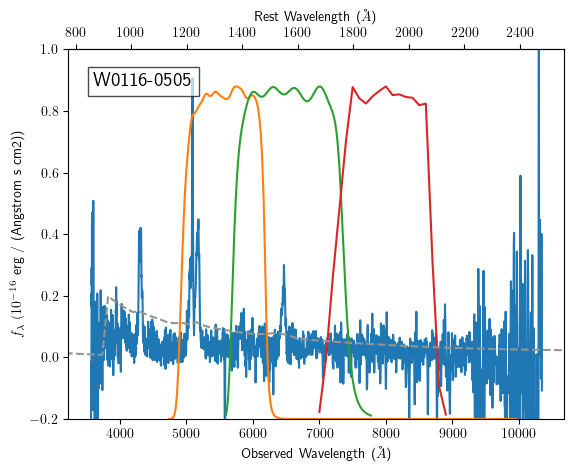

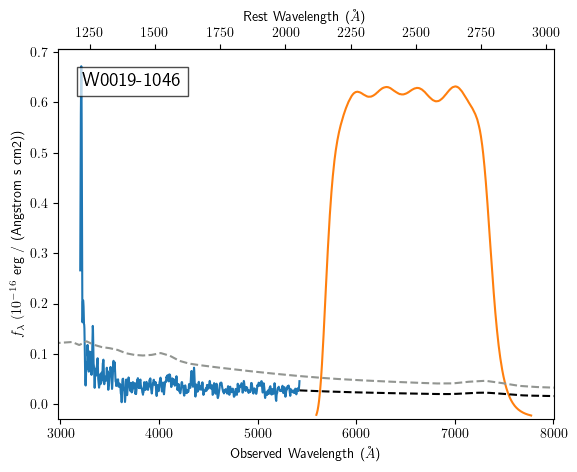

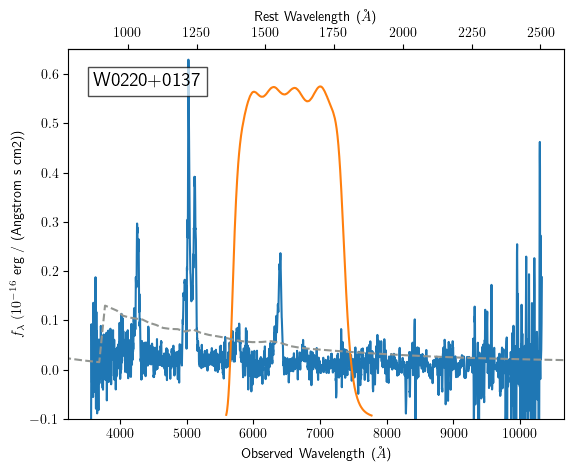

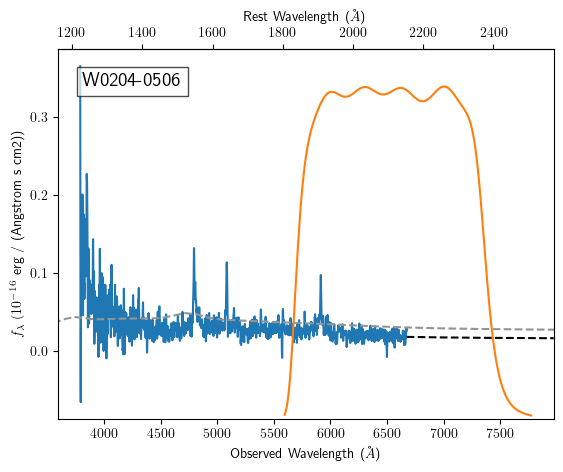

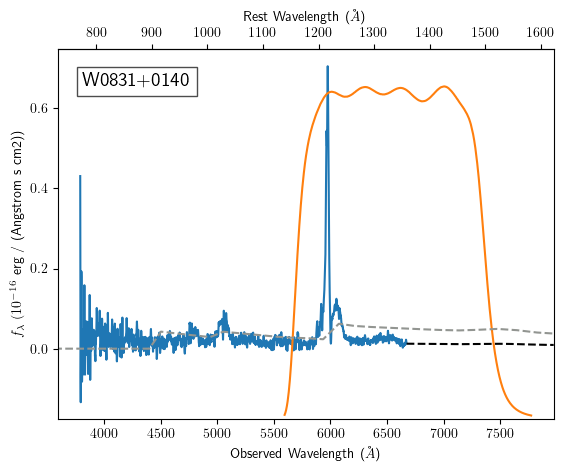

In [9]:
import matplotlib.transforms as transforms

#wid = "W0019-1046"
for wid in pol_data.keys():
    bands = load_bands(pol_data[wid]['bands'])

    spec = pol_data[wid]['spec']

    full_spec = SourceSpectrum(Empirical1D, points=spec.lam_obs, lookup_table=spec.flam, keep_neg=True)

    fig, ax = plt.subplots(1)
    trans = transforms.blended_transform_factory(ax.transData, ax.transAxes)

    #Smooth the spectrum 
    flam_smooth = savgol_filter(spec.flam, 11, 3)*1e16
    #ax.plot(spec.lam_obs/(1+spec.zspec), spec.flam, label=wid)
    ax.plot(spec.lam_obs, flam_smooth, label=wid)

    #Add a secondary axis with the rest-frame wavelengths. 
    invert = lambda x:x/(1+spec.zspec) 
    sax = ax.secondary_xaxis('top',functions=(invert, invert))

    #Plot the filtercurves
    for band in bands:
        ax.plot(band._model.points[0], 0.9*band._model.lookup_table/np.max(band._model.lookup_table), transform=trans)

    #Also plot the best-fit SED.
    ax.set_xlim(ax.get_xlim())
    ax.set_ylim(ax.get_ylim())
    sed_lam_obs, sed_flam = read_sed(wid, spec.zspec)
    sed_flam = sed_flam.to(spec.flam.unit)*1e16
    ax.plot(sed_lam_obs.to(u.AA).value, sed_flam.value, ls='dashed', color='xkcd:gray')

    #Now, let's do an extrapolation of the spectrum.
    lam_obs_ex, flam_ex = extrapolate_spec(spec, wid)
    flam_ex = flam_ex.to(spec.flam.unit)*1e16
    ax.plot(lam_obs_ex[len(spec.flam):].value, flam_ex[len(spec.flam):].value, ls='dashed', color='black')

    #Add a label with the object name
    ax.text(0.05, 0.9, wid, transform=ax.transAxes, bbox=dict(facecolor='white', edgecolor='black', alpha=0.7), fontsize=14)

    #Set the y-axis range for some objects. 
    if wid == "W0116-0505":
        ax.set_ylim([-0.2, 1.0])
    elif wid == "W0220+0137":
        ax.set_ylim([-0.1, 0.65])

    #Set the axis labels. 
    ax.set_xlabel(r"Observed Wavelength ($\AA$)")
    sax.set_xlabel(r"Rest Wavelength ($\AA$)")
    ax.set_ylabel(r"$f_{\lambda}~(10^{-16}$" + " {})".format(spec.flam.unit))
    plt.show()


In [35]:
wid = "W0204-0506"
band = "R"
spec = pol_data[wid]['spec']
dust_model = "LMC"
fw = False
bw = True

In [36]:
bands = load_bands(pol_data[wid]['bands'])

In [37]:
p_bb = get_p_bb(dust_model, theta_angles, psi_angles, spec, wid, [bands[0]], fw=fw, bw=bw)

In [38]:
s1_bb = get_s1_bb(dust_model, theta_angles, psi_angles, spec, wid, [bands[0]], fw=fw, bw=bw)

In [48]:
#For W0204-0506, find the combination of angles that give the highest polarization. 
k = np.unravel_index(np.argmax(p_bb), p_bb.shape)
print(k, p_bb[k], np.max(p_bb))
th = theta_angles[k[1]]
psi = theta_angles[k[2]]
NH = 2 * pol_data[wid]['eps']*np.cos(psi) / s1_bb[k]
print(NH)
#np.unravel_index(k, p_bb.shape))
#print(theta_angles[16], psi_angles[0])

(0, 16, 0) 0.19520809911542075 0.19520809911542075
7.556238166321878e+23
